# **Energy consumption measurement using RAPL Report**

**Course:** Complex IT Systems  
**Author:** Eray Erkul  
**Date:** 18 October 2025  

---

**References:**
Mostly code are used from the **"comparing samples from normal distrubution.ipynb"** and **"comparing two non-normal distrbutions by random sampling.ipynb"** on the moodle. The article, **"RAPL in Action: Experiences in Using RAPL for Power Measurements"** was also used.

"DETERMINATION OF SAMPLE SIZE AND SAMPLING METHODS IN APPLIED RESEARCH" - DOI:10.24874/PES03.01.003.

Lastly **AI** was also used to give an overview of my project and if i had missed something from the requirements. Few code was used with AI and modified by me to match with the needs i had. These places are noted as #AI as a comment next to the code.

## 1. Research questions and Hypothesis

## **1.1 Research Question**

**Overall Question:**  
Which software characteristic has the largest impact on energy consumption compared to CPU-intensive workloads?

**Precise Research Question:**  
Given equal execution time for both CPU and DRAM, do DRAM‑intensive workloads use less energy than CPU‑bound workloads, even with frequent memory accesses?

---

### **1.2 Hypotheses** 

**Null Hypothesis (H₀):**  
There is **no significant difference** in energy consumption between DRAM heavey workloads and CPU-bound workloads.

**Alternative Hypothesis (H₁):**  
There is a **significant difference** in energy consumption. DRAM heavy workloads consume less energy than CPU-bound workloads.

---

### **1.3 Variables**
**Independent variable:**  
The independent variable in this experiment is the stress tests for CPU and memory (DRAM). The memory stress code was adjusted to match the structure of the code used for the other classes.

**Dependent variable:**  
The dependent variable is the energy consumption that CPU and memory use during the test and is measured by using RAPL. 

**Choice of Dependent Variables**
Memory (DRAM) was chosen because it stores data temporarily while programs are running. It is fast and can use a lot of energy under load, but i believe it uses less energy than the CPU.

**Controlled variables:**
All tests are conducted under the following controlled conditions:
- Hardware: All test PCs use identical hardwares.
- Operating system: All PCs run the same Linux and version (Ubuntu Server 24.04 LTS).
- Power and services: Laptops are connected to a power supply, and background services are disabled.
- Cooling and environment: Tests are done at similar device temperatures, on the same surface, and under similar surrounding conditions.

**Comfounding variables**:
- Outcome of the memory stress test has negative numbers.
- Small differences in temperature or how well the computer was cooled could have affected how much power the CPU or memory used.
- dbus service was not disabled and might have an affect.
---

## **2. Methodology** SKRIV DEN LIDT OM

In this experiment, we measure the energy consumption of CPU-intensive and memory i.e DRAM-intensive workloads. To do this, we use Intel’s Running Average Power Limit (RAPL) feature, which measures accurate energy consumption data from the CPU. Stress-ng is used to run different workloads that simulate heavy CPU and memory usage. 
The experiment was conducted on a Dell Latitude laptop with the following specifications:

- Intel® Core™ i5-8350U @ 1.70GHz
- System Memory: 16 GiB RAM
- Storage: CA3-8D256-Q11 NVMe LITEON 256 GB
- Display: Intel UHD Graphics 620

All services were disabled during stress testing, although dbus could not be disabled.

To determine the sample size for the experiment, Cochran’s formula is applied: $n = \frac{Z^2 * p * q}{e^2}$
- Z is the Z-score i.e conffidence level. (For a 95% confidence interval, the Z-score from the standard normal distribution is 1.96.)
- p is the estimated proportion of the population. (Since we do not have prior information about the data, we use 0.5 as a conservative estimate.)
- q is 1 - p
- and e is the Desired margin of error (precision). (Chosen value is 0.05 which means that the result should be within 5% of the actual population.)

Cochran’s sample size formula helps researchers figure out how many participants or data points are needed for a study. 
For this study, a 95% confidence level will be used.

In [2]:
z = 1.96
p = 0.5
q = 1 - p
e = 0.05

n = (z**2 * p * q)/e**2
print(f"Calculated sample size for the study: {n}")

Calculated sample size for the study: 384.1599999999999


Stress-ng stress tests were performed in 400 times for both CPU and Memory classes, with each time lasting 20 seconds. Based on Cochran's formula, at least 384 runs were required to ensure the sample size was large enough for a reliable analysis.

## KOM IND PÅ EXPERIMENTAL SETUP OG CONTROLLED SETUP HER

The stress test results were saved in a CSV file. Only the energy consumption measurements of the CPU, the package (PKG) and execution time are included. Measurements from NN and NN2 are excluded.

To whether accept or reject the null hypotheses, I must perform a statistical analysis

In [13]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import math 
import random

Before starting to work on the data, i need to make sure that the data formatation is correct, for example, i need to change the ';' into a ','. To do this, using sep= will do the job.

In [14]:
data_CPU = pd.read_csv('../Data/cpu-stress-ng.csv', sep=r'[;,\s]+', engine='python', names=['test','PKG','CPU','time']) #AI was used here i.e. AI added sep=r'[;,\s]+', engine='python'
data_CPU

,test,PKG,CPU,time
0,cpu,780.842224,749.859436,20296.5
1,cpu,479.237854,450.172913,20398.4
2,cpu,445.622253,418.648560,20244.8
3,cpu,447.585815,415.841675,20418.0
4,cpu,447.605896,416.566711,20353.9
...,...,...,...,...
395,cpu,386.230713,353.864685,20516.5
396,cpu,373.332092,342.597961,20320.0
397,cpu,382.693298,351.696472,20525.8
398,cpu,388.489990,356.199036,20552.2


In [15]:
data_memory = pd.read_csv('../Data/memory-stress-ng.csv', sep=r'[;,\s]+', engine='python', names=['test','PKG','CPU','time'])
data_memory

,test,PKG,CPU,time
0,memory,484.963074,423.709290,23240.3
1,memory,446.409363,383.956543,23038.3
2,memory,468.358276,407.212402,23149.1
3,memory,468.924866,405.436584,23085.6
4,memory,483.161377,423.068176,23133.6
...,...,...,...,...
395,memory,439.955383,371.022034,23800.9
396,memory,239.430481,183.562012,23779.2
397,memory,420.123962,358.072510,22604.3
398,memory,448.154541,381.284973,23190.3


Then i will combine both dataframeworks by using merge (outer function).

In [16]:
concat_two_frameworks = pd.merge(data_CPU, data_memory, on='test', how='outer' )

concat_two_frameworks['PKG'] = concat_two_frameworks['PKG_x'].combine_first(concat_two_frameworks['PKG_y'])
concat_two_frameworks['CPU'] = concat_two_frameworks['CPU_x'].combine_first(concat_two_frameworks['CPU_y'])
concat_two_frameworks['time']= concat_two_frameworks['time_x'].combine_first(concat_two_frameworks['time_y'])

combined_df = concat_two_frameworks[['test','PKG','CPU','time']]
combined_df

,test,PKG,CPU,time
0,cpu,780.842224,749.859436,20296.5
1,cpu,479.237854,450.172913,20398.4
2,cpu,445.622253,418.648560,20244.8
3,cpu,447.585815,415.841675,20418.0
4,cpu,447.605896,416.566711,20353.9
...,...,...,...,...
795,memory,439.955383,371.022034,23800.9
796,memory,239.430481,183.562012,23779.2
797,memory,420.123962,358.072510,22604.3
798,memory,448.154541,381.284973,23190.3


In [ ]:
#Removing 20 seconds on the time column to start from 0 seconds
#combined_df['time'] = combined_df['time'] - 20000
#combined_df

C:\Users\eray2\AppData\Local\Temp\ipykernel_25772\4256400275.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df['time'] = combined_df['time'] - 20000


,test,PKG,CPU,time
0,cpu,780.842224,749.859436,296.5
1,cpu,479.237854,450.172913,398.4
2,cpu,445.622253,418.648560,244.8
3,cpu,447.585815,415.841675,418.0
4,cpu,447.605896,416.566711,353.9
...,...,...,...,...
795,memory,439.955383,371.022034,3800.9
796,memory,239.430481,183.562012,3779.2
797,memory,420.123962,358.072510,2604.3
798,memory,448.154541,381.284973,3190.3


To get an overview about the data we can use describe() and make some plots about the data.

In [18]:
combined_df.describe()

,PKG,CPU,time
count,800.000000,800.000000,800.000000
mean,75.523317,27.739339,1936.753000
std,9276.013416,9266.708860,1710.199352
min,-261955.759705,-261740.741150,213.000000
25%,384.326294,351.949402,331.075000
50%,397.559082,362.471436,1291.100000
75%,447.528870,388.768463,3303.325000
max,780.842224,749.859436,8488.300000


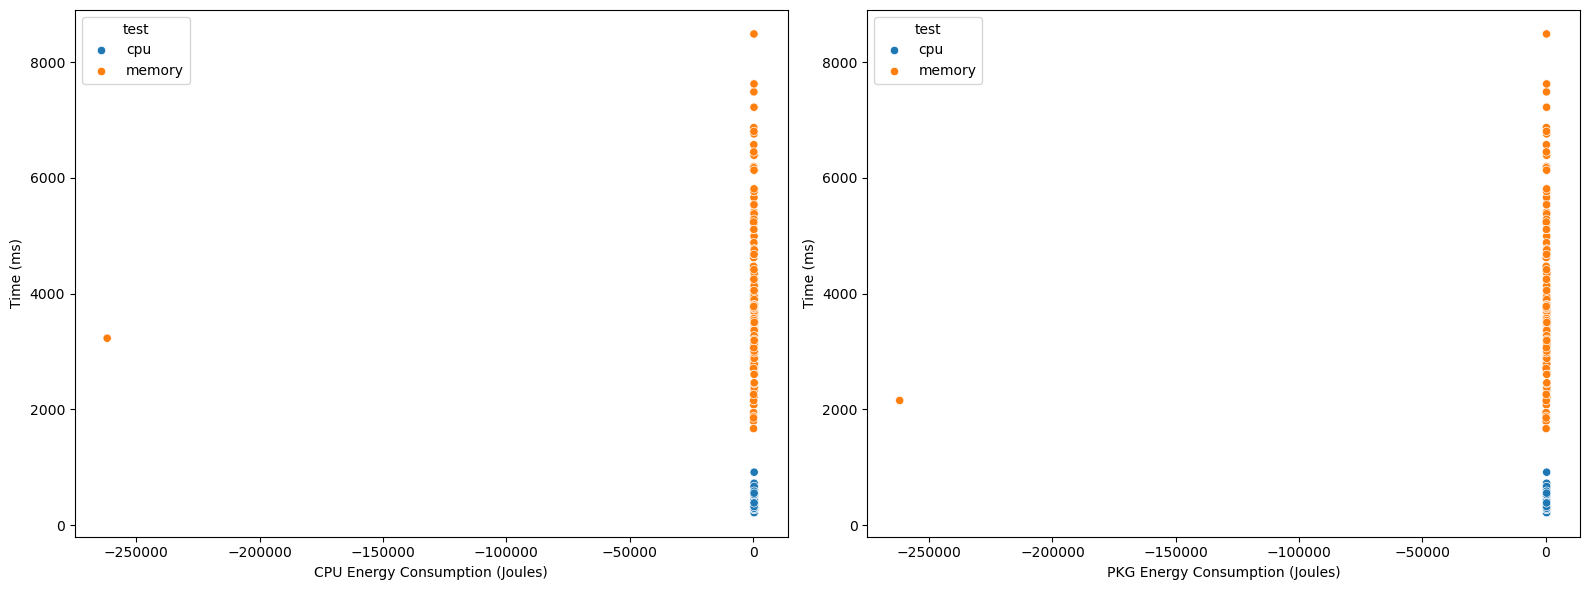

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))


# CPU scatterplot
sns.scatterplot(data=combined_df, hue='test', x='CPU', y='time', ax=axes[0])
axes[0].set_xlabel("CPU Energy Consumption (Joules)")
axes[0].set_ylabel("Time (ms)")

# PKG scatterplot
sns.scatterplot(data=combined_df, hue='test', x='PKG', y='time', ax=axes[1])
axes[1].set_xlabel("PKG Energy Consumption (Joules)")
axes[1].set_ylabel("Time (ms)")

plt.tight_layout()
plt.show()

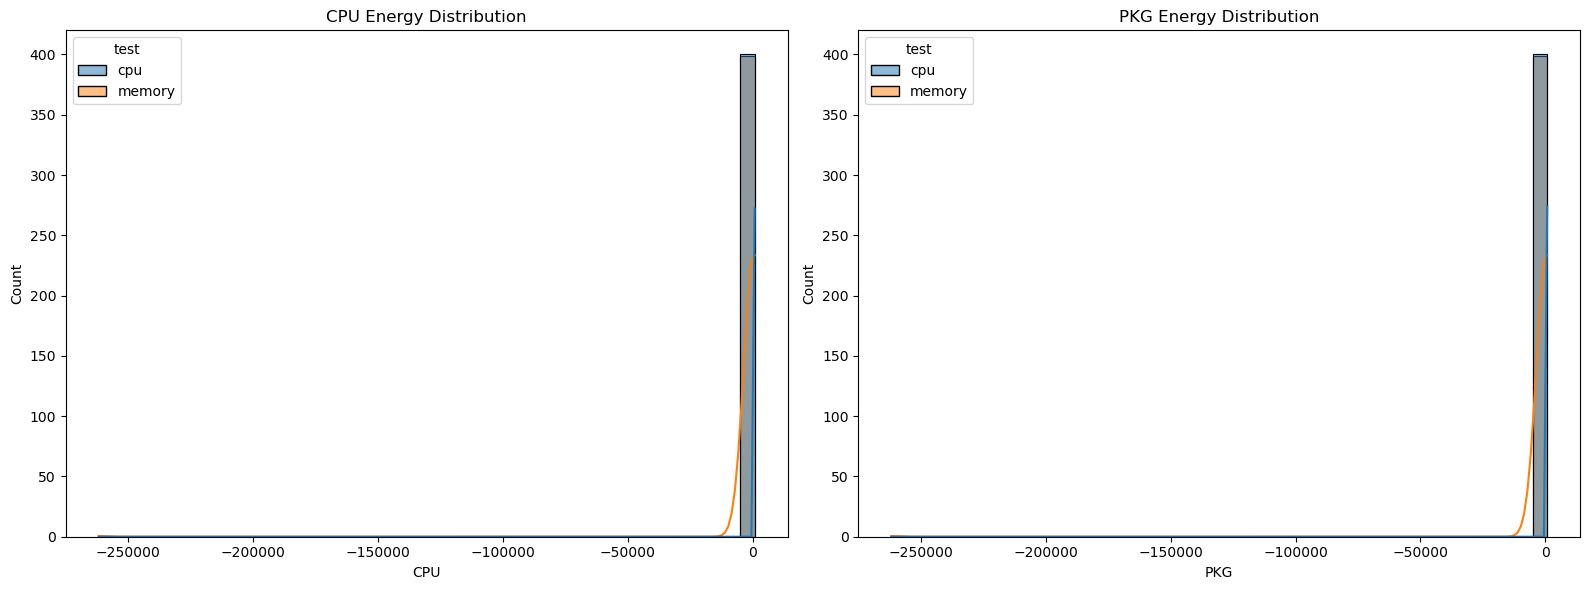

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# CPU histogram
sns.histplot(data=combined_df, hue='test', bins=45, kde=True, stat="count", x='CPU', ax=axes[0])
axes[0].set_title("CPU Energy Distribution")

# PKG histogram
sns.histplot(data=combined_df, hue='test', bins=45, kde=True, stat="count", x='PKG', ax=axes[1])
axes[1].set_title("PKG Energy Distribution")

plt.tight_layout()
plt.show()

The histogram shows that the memory data is somewhat normally distributed but shows a long left skew, while the CPU data has two peaks, one bigger than the other, indicating a bimodal distribution.

I can see on the min and scatterplot that there are negative numbers and outliers, so they must be removed.
I will check for which group has negative values.

In [21]:
for col in ['PKG', 'CPU', 'time']:
    any_negatives = (data_CPU[col] < 0).any()
    print(f"Any negatives in '{col}'? {any_negatives}")

Any negatives in 'PKG'? False
Any negatives in 'CPU'? False
Any negatives in 'time'? False


In [22]:
for col in ['PKG', 'CPU', 'time']:
    any_negatives = (data_memory[col] < 0).any()
    print(f"Any negatives in '{col}'? {any_negatives}")

Any negatives in 'PKG'? True
Any negatives in 'CPU'? True
Any negatives in 'time'? False


Both groups have negative numbers.

In [23]:
for col in ['PKG', 'CPU', 'time']:
    any_negatives = (combined_df[col] < 0).any()
    print(f"Any negatives in '{col}'? {any_negatives}")

Any negatives in 'PKG'? True
Any negatives in 'CPU'? True
Any negatives in 'time'? False


And the overall combined dataframe do of course also have negative numbers

Therefore i will remove all negative values

In [24]:
combined_df = combined_df[(combined_df['PKG'] >= 0) & (combined_df['CPU'] >= 0)]
combined_df.describe()

,PKG,CPU,time
count,798.000000,798.000000,798.000000
mean,403.389869,355.638700,1934.860526
std,63.016645,62.314950,1711.712725
min,167.596069,113.093567,213.000000
25%,384.371262,352.025940,331.025000
50%,397.559082,362.501160,819.050000
75%,447.474716,388.898407,3304.175000
max,780.842224,749.859436,8488.300000


In [25]:
for col in ['PKG', 'CPU', 'time']:
    any_negatives = (combined_df[col] < 0).any()
    print(f"Any negatives in '{col}'? {any_negatives}")

Any negatives in 'PKG'? False
Any negatives in 'CPU'? False
Any negatives in 'time'? False


Now that the negative numbers are removed, we can remove the outliers

One way to check for outliers is to use a boxplot

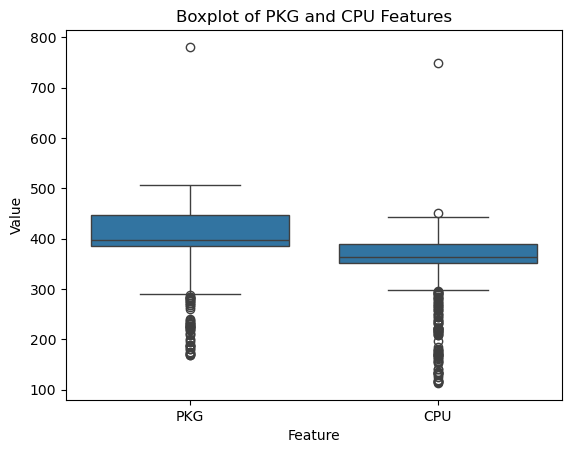

In [26]:
df_multi = combined_df.melt(value_vars=['PKG','CPU'], var_name='Feature', value_name='Value')
sns.boxplot(x='Feature', y='Value', data=df_multi)
plt.title('Boxplot of PKG and CPU Features')
plt.show()

As seen on the figure, we do have a lot of outliers.

In [27]:
df_cpu = combined_df[combined_df['test'] == 'cpu']
df_memory = combined_df[combined_df['test'] == 'memory']

In [28]:
# Remove outliers from the initial data (per sample) 
# use quantile outliers when we do not have normal distributed data
def remove_outliers_quantile(data_series):
    data = data_series
    q75, q25 = data.quantile(q=0.75),data.quantile(q=0.25) # np.percentile(data.loc[:,data_column],[75,25])
    intr_qr = q75 - q25

    max = q75 + (1.5 * intr_qr)
    min = q25 - (1.5 * intr_qr)

    count_total = len(data)

    data = data[(data > min) & (data < max)]
    count_wo_outliers = len(data)

    outliers_count = count_total - count_wo_outliers
    print(f'number of outliers: {outliers_count} of {count_total} observations.')
    
    # remove outliers
    return data

df_cpu.loc[:,'CPU'] = remove_outliers_quantile(df_cpu['CPU'])
df_memory.loc[:,'CPU'] = remove_outliers_quantile(df_memory['CPU'])
df_cpu.loc[:,'PKG'] = remove_outliers_quantile(df_cpu['PKG'])
df_memory.loc[:,'PKG'] = remove_outliers_quantile(df_memory['PKG'])


number of outliers: 53 of 400 observations.
number of outliers: 31 of 398 observations.
number of outliers: 51 of 400 observations.
number of outliers: 36 of 398 observations.


Now that the outliers are removed we can also remove all NaN

In [29]:
df_cpu_clean = df_cpu.dropna(subset=['CPU', 'PKG', 'time'])
df_memory_clean = df_memory.dropna(subset=['CPU', 'PKG', 'time'])

cleaned_df = pd.concat([df_cpu_clean, df_memory_clean]).reset_index(drop=True)
cleaned_df.head()


,test,PKG,CPU,time
0,cpu,422.314758,392.804626,286.6
1,cpu,425.059509,393.858337,309.4
2,cpu,427.639771,396.109741,329.1
3,cpu,425.702393,394.623901,258.4
4,cpu,426.337769,395.063904,426.0


Checking if there is any NaN.

In [30]:
cleaned_df.isna().sum()

test    0
PKG     0
CPU     0
time    0
dtype: int64

Now i can observe my data again with graphs.



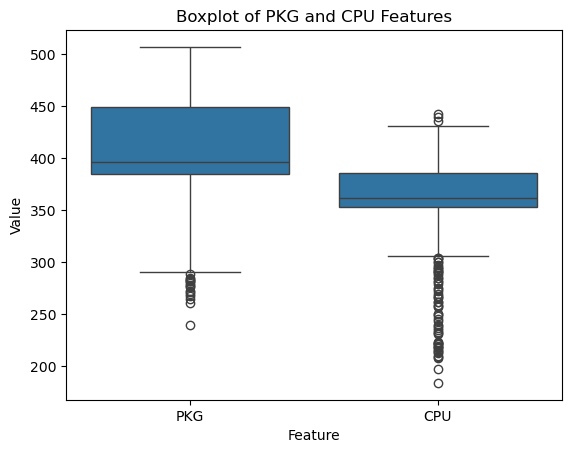

In [31]:
df_multi_updated = cleaned_df.melt(value_vars=['PKG','CPU'], var_name='Feature', value_name='Value')
sns.boxplot(x='Feature', y='Value', data=df_multi_updated)
plt.title('Boxplot of PKG and CPU Features')
plt.show()

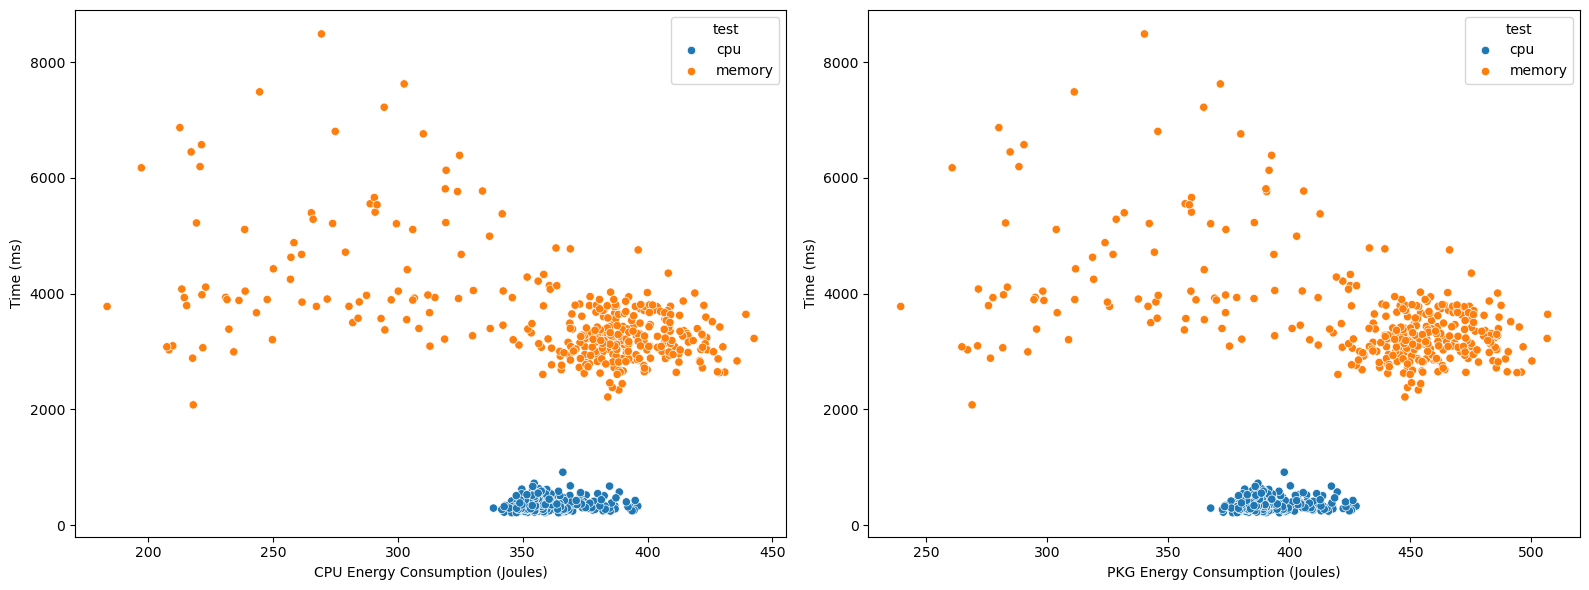

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))


# CPU scatterplot
sns.scatterplot(data=cleaned_df, hue='test', x='CPU', y='time', ax=axes[0])
axes[0].set_xlabel("CPU Energy Consumption (Joules)")
axes[0].set_ylabel("Time (ms)")

# PKG scatterplot
sns.scatterplot(data=cleaned_df, hue='test', x='PKG', y='time', ax=axes[1])
axes[1].set_xlabel("PKG Energy Consumption (Joules)")
axes[1].set_ylabel("Time (ms)")

plt.tight_layout()
plt.show()

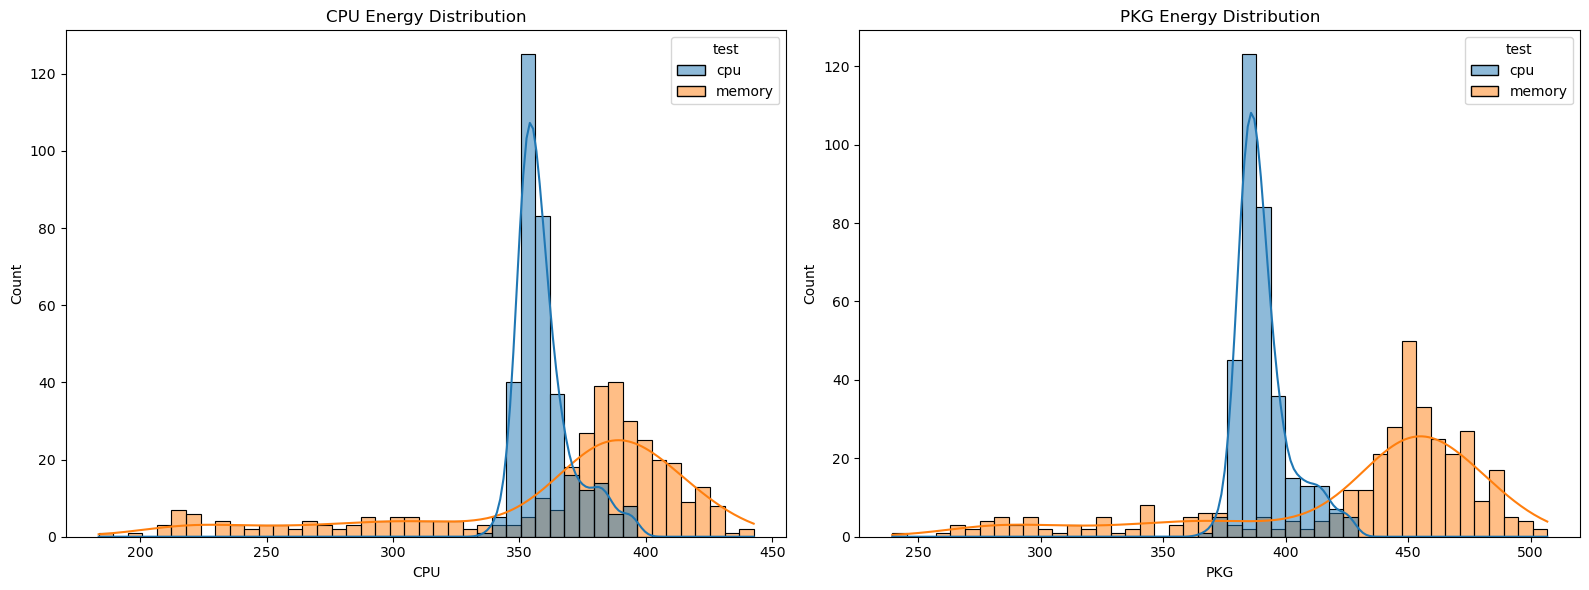

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# CPU histogram
sns.histplot(data=cleaned_df, hue='test', bins=45, kde=True, stat="count", x='CPU', palette='tab10', ax=axes[0])
axes[0].set_title("CPU Energy Distribution")

# PKG histogram
sns.histplot(data=cleaned_df, hue='test', bins=45, kde=True, stat="count", x='PKG', palette='tab10', ax=axes[1])
axes[1].set_title("PKG Energy Distribution")

plt.tight_layout()
plt.show()

Now that the outliers are removed, i can test my data to see if my data is normal distributed or not to wether reject or not to reject my hypotheses.

## Using Shapiro-Wilk Test to test for normality
First i wanna use Shapiro-Wilk Test to test whether my samples have a Gaussian distribution or not.

**Assumptions:**
Observations in each sample are independent and identically distributed (iid).

**Interpretation:**
- H0: the sample has a Gaussian distribution.
- H1: the sample does not have a Gaussian distribution.

In [124]:
# Example of the Shapiro-Wilk Normality Test
from scipy.stats import shapiro
data = cleaned_df[cleaned_df['test']=='cpu']['CPU']
stat, p = shapiro(data)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably Gaussian')
else:
	print('Probably not Gaussian')

stat=0.872, p=0.000
Probably not Gaussian


In [125]:
# Example of the Shapiro-Wilk Normality Test
from scipy.stats import shapiro
data = cleaned_df[cleaned_df['test']=='cpu']['PKG']
stat, p = shapiro(data)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably Gaussian')
else:
	print('Probably not Gaussian')

stat=0.882, p=0.000
Probably not Gaussian


In [126]:
# Example of the Shapiro-Wilk Normality Test
from scipy.stats import shapiro
data = cleaned_df[cleaned_df['test']=='memory']['CPU']
stat, p = shapiro(data)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably Gaussian')
else:
	print('Probably not Gaussian')

stat=0.823, p=0.000
Probably not Gaussian


In [127]:
# Example of the Shapiro-Wilk Normality Test
from scipy.stats import shapiro
data = cleaned_df[cleaned_df['test']=='memory']['PKG']
stat, p = shapiro(data)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably Gaussian')
else:
	print('Probably not Gaussian')

stat=0.817, p=0.000
Probably not Gaussian


All p-values are close to 0, which means I can reject the null hypothesis and therefore it is not normally distributed.

To have further proofs, i will be also testing D’Agostino’s K^2 Test to test if the samples are normal distrubuted.

## D’Agostino’s K^2 Test
Tests whether a data sample has a Gaussian distribution.

**Assumptions**:
Observations in each sample are independent and identically distributed (iid).

**Interpretation:**
- H0: the sample has a Gaussian distribution.
- H1: the sample does not have a Gaussian distribution

In [128]:
# Example of the D'Agostino's K^2 Normality Test
from scipy.stats import normaltest
data = cleaned_df[cleaned_df['test']=='cpu']['CPU']
stat, p = normaltest(data)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably Gaussian')
else:
	print('Probably not Gaussian')

stat=86.218, p=0.000
Probably not Gaussian


In [129]:
# Example of the D'Agostino's K^2 Normality Test
from scipy.stats import normaltest
data = cleaned_df[cleaned_df['test']=='cpu']['PKG']
stat, p = normaltest(data)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably Gaussian')
else:
	print('Probably not Gaussian')

stat=81.031, p=0.000
Probably not Gaussian


In [130]:
# Example of the D'Agostino's K^2 Normality Test
from scipy.stats import normaltest
data = cleaned_df[cleaned_df['test']=='memory']['CPU']
stat, p = normaltest(data)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably Gaussian')
else:
	print('Probably not Gaussian')

stat=79.663, p=0.000
Probably not Gaussian


In [131]:
# Example of the D'Agostino's K^2 Normality Test
from scipy.stats import normaltest
data = cleaned_df[cleaned_df['test']=='memory']['PKG']
stat, p = normaltest(data)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably Gaussian')
else:
	print('Probably not Gaussian')

stat=83.512, p=0.000
Probably not Gaussian


Yet again I can reject the null hypothesis. The p-value is close to 0 and is probably not normally distributed.

Because the data is not normally distributed, I will perform tests for non-normal distributions.

In [132]:
# define the data source and how to separate the data (which test is program A and which is program B)
data = cleaned_df
data_column = 'CPU'         # The column name with the data that we want to compare
types_column_name = 'test'  # The column name with the data in it
programA = 'cpu'  # The category of data A
programB = 'memory'       # The category of data B

repetitions_of_random_sampling = 10000

# create a new dataframe with the interesting subset 
data_set=data[(data[types_column_name]==programA) | (data[types_column_name]==programB)]
data_set.reset_index()

# count the number of samples in each data set 
count_A = data[data[types_column_name]==programA][types_column_name].count()
count_B = data[data[types_column_name]==programB][types_column_name].count()
org_mean_diff = data[data[types_column_name]==programA][data_column].mean()-data[data[types_column_name]==programB][data_column].mean()
if count_A != count_B: print(f"Warning: The data original data sets do not have equally many elements: Data set A has {count_A} elements and Data set B has {count_B} elements")
                              
total = count_A+count_B
fact_r = math.factorial(total)

max_combinations = math.factorial(total) /(math.factorial(count_A) * math.factorial(total-count_A))
if max_combinations < repetitions_of_random_sampling: 
    print(f"Warning: The number of possible combinations when picking {count_A} elements from {total} elements is {max_combinations} and you have chosen {repetitions_of_random_sampling} repetitions, thus including some repetitions.")
                              
list_index = list(range(total))

mean_diffs_cpu = []
for i in range(repetitions_of_random_sampling):
    samples = random.sample(list_index,total)
    sampleA_index = samples[:count_A]
    sampleB_index = samples[count_A:]
    
    sampleA = data_set.iloc[sampleA_index]
    sampleB = data_set.iloc[sampleB_index]
    
    mean_diff = sampleA[data_column].mean()-sampleB[data_column].mean()
    mean_diffs_cpu.append(mean_diff)

In [133]:
# define the data source and how to separate the data (which test is program A and which is program B)
data = cleaned_df
data_column = 'PKG'         # The column name with the data that we want to compare
types_column_name = 'test'  # The column name with the data in it
programA_cpu = 'cpu'  # The category of data A
programB_memory = 'memory'       # The category of data B

repetitions_of_random_sampling = 10000

# create a new dataframe with the interesting subset 
data_set=data[(data[types_column_name]==programA) | (data[types_column_name]==programB)]
data_set.reset_index()

# count the number of samples in each data set 
count_A = data[data[types_column_name]==programA][types_column_name].count()
count_B = data[data[types_column_name]==programB][types_column_name].count()
org_mean_diff = data[data[types_column_name]==programA][data_column].mean()-data[data[types_column_name]==programB][data_column].mean()
if count_A != count_B: print(f"Warning: The data original data sets do not have equally many elements: Data set A has {count_A} elements and Data set B has {count_B} elements")
                              
total = count_A+count_B
fact_r = math.factorial(total)

max_combinations = math.factorial(total) /(math.factorial(count_A) * math.factorial(total-count_A))
if max_combinations < repetitions_of_random_sampling: 
    print(f"Warning: The number of possible combinations when picking {count_A} elements from {total} elements is {max_combinations} and you have chosen {repetitions_of_random_sampling} repetitions, thus including some repetitions.")
                              
list_index = list(range(total))

mean_diffs_pkg = []
for i in range(repetitions_of_random_sampling):
    samples = random.sample(list_index,total)
    sampleA_index = samples[:count_A]
    sampleB_index = samples[count_A:]
    
    sampleA = data_set.iloc[sampleA_index]
    sampleB = data_set.iloc[sampleB_index]
    
    mean_diff = sampleA[data_column].mean()-sampleB[data_column].mean()
    mean_diffs_pkg.append(mean_diff)

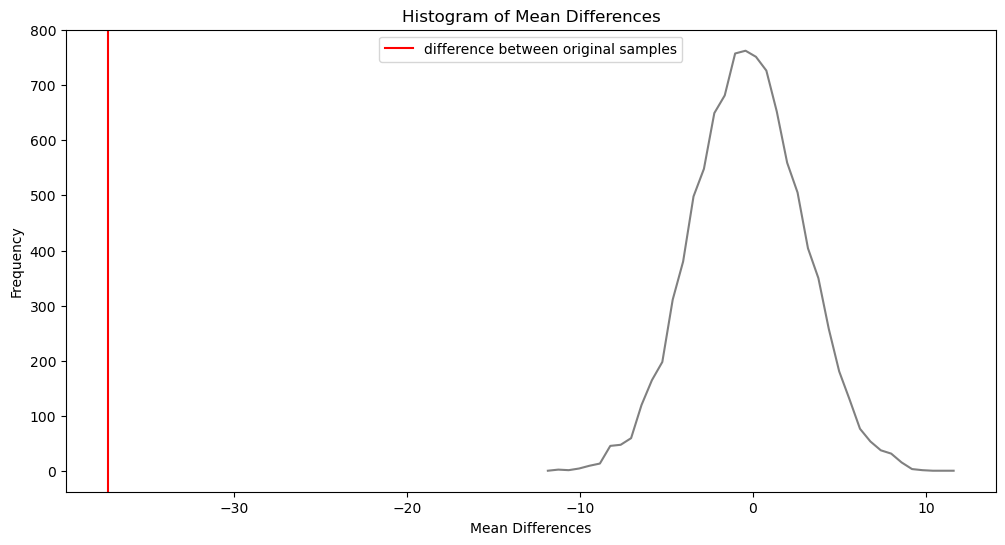

In [134]:
# evaluate the histogram
fig, ax = plt.subplots(figsize=(12, 6))
values, base = np.histogram(mean_diffs_cpu, bins=40)
plt.plot(base[:-1], values, c='gray')
# a red line indicating the original difference between the averages of the original samples 
plt.axvline(x = org_mean_diff, color = 'red', label = 'difference between original samples')

ax.set_xlabel('Mean Differences')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Mean Differences')
ax.legend()

plt.show()

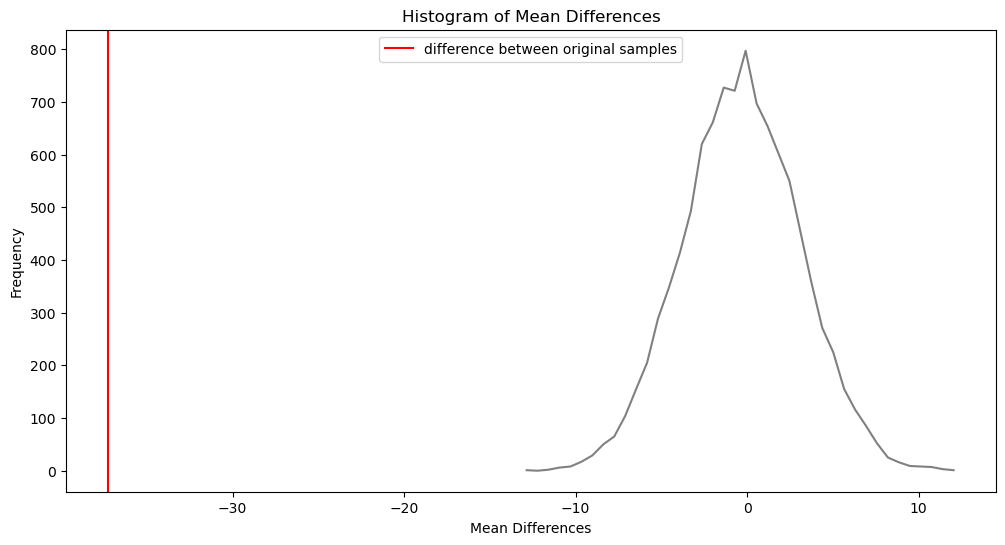

In [135]:
# evaluate the histogram
fig, ax = plt.subplots(figsize=(12, 6))
values, base = np.histogram(mean_diffs_pkg, bins=40)
plt.plot(base[:-1], values, c='gray')
# a red line indicating the original difference between the averages of the original samples 
plt.axvline(x = org_mean_diff, color = 'red', label = 'difference between original samples')

ax.set_xlabel('Mean Differences')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Mean Differences')
ax.legend()

plt.show()

Both graphs show that the red line is outside the gray histogram of mean differences.

In [136]:
empirical_p_cpu = np.count_nonzero(pd.Series(mean_diffs_cpu) <= org_mean_diff) / repetitions_of_random_sampling
empirical_p_memory = np.count_nonzero(pd.Series(mean_diffs_pkg) <= org_mean_diff) / repetitions_of_random_sampling
print(f"Empirical p-value for CPU: {empirical_p_cpu} and for Memory: {empirical_p_memory}")

Empirical p-value for CPU: 0.0 and for Memory: 0.0


In [137]:
# conclusion:
print(f"If the empirical p-value is 0, it means that none of the {repetitions_of_random_sampling} permuted samples "+
       f"resulted in a difference of {org_mean_diff} or lower. This is only an approximation. "+
       "The probability of getting a difference in that range is not 0, but it is very small, "+
       "according to our simulation. Therefore we can reject the null hypothesis.")

If the empirical p-value is 0, it means that none of the 10000 permuted samples resulted in a difference of -37.25440618640221 or lower. This is only an approximation. The probability of getting a difference in that range is not 0, but it is very small, according to our simulation. Therefore we can reject the null hypothesis.


##  **3. Interpretation and Discussion**

The gray curve shows what kind of differences i would expect to see if there was actually no real difference between the two groups (CPU and Memory) means.
Most of the gray values are centered around 0, meaning that when i randomly shuuffle the data, the mean difference usually ends up close to zero.
The red line shows the actual difference between the two original groups, and since it is far away from the gray curve, it means the difference is not something that would happen by random chance. Therefore, i can reject the null hypothesis, because there is likely a real difference between the CPU and Memory groups.